In this notebook I will build simple Perceptron and FCN start using class structure. 

# Perceptron

First, let's implement simple perceptron from scratch using torch tensors.

In [25]:
import torch
import pandas as pd

For the first test let's have some blobs that are linearly sepperable.

In [470]:
def make_dataset(level, n=100):
    """Generates simple, harder and hard problem using blobs."""
    X_cases = [torch.normal(-1. if level == 'simple' else 0., 0.3, (n, 2)),
               torch.normal(1., 0.3, (n, 2))]
    y_cases = [torch.ones(n), torch.zeros(n)]
    n_cases = 2 * n
    if level == 'hard':
        X_cases.append(torch.normal(2., 0.3, (n, 2)))
        y_cases.append(torch.ones(n))
        n_cases += n
    # Shufling
    mask = torch.randperm(n_cases)
    X, y = torch.vstack(X_cases)[mask], torch.hstack(y_cases)[:, None][mask]
    pd.DataFrame(torch.hstack([X, y]).numpy(), columns=['x', 'y', 'label']).plot(
    kind='scatter', x='x', y='y', c='label', cmap='inferno')
    return X, y

Now we are ready to create perceptron

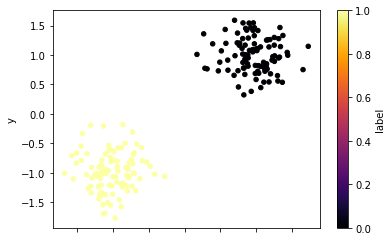

In [471]:
X, y = make_dataset('simple')

In [472]:
epochs = 10
learning_rate = 0.1
W = torch.rand((2, 1))

for _ in range(epochs):
    errors = (2 * y - 1) - torch.sign(X @ W)
    print('Error - {0:.01%}'.format(torch.mean(torch.abs(torch.sign(errors)))))
    W += learning_rate * X.T @ errors

Error - 100.0%
Error - 0.0%
Error - 0.0%
Error - 0.0%
Error - 0.0%
Error - 0.0%
Error - 0.0%
Error - 0.0%
Error - 0.0%
Error - 0.0%


Now, let's use proper sigmoid instead

In [473]:
epochs = 5
learning_rate = 0.3
W = torch.rand((2, 1))

for _ in range(epochs):
    y_hat = torch.sigmoid(X @ W)
    errors = y - y_hat
    diff = y_hat * (1 - y_hat)
    print('Error - {0:.01%}'.format(torch.mean(torch.abs(errors))))
    W += learning_rate * X.T @ (errors * diff)

Error - 77.0%
Error - 0.0%
Error - 0.0%
Error - 0.0%
Error - 0.0%


For sure if we make problem slightly harder it will fail.

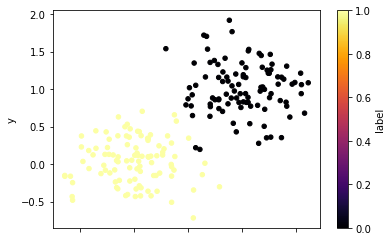

In [474]:
X, y = make_dataset('harder')

In [475]:
epochs = 10
learning_rate = 0.4
W = torch.rand((2, 1))

for _ in range(epochs):
    y_hat = torch.sigmoid(X @ W)
    errors = y - y_hat
    diff = y_hat * (1 - y_hat)
    print('Error - {0:.01%}'.format(torch.mean(torch.abs(errors))))
    W += learning_rate * X.T @ (errors * diff)

Error - 58.8%
Error - 26.8%
Error - 26.7%
Error - 26.7%
Error - 26.7%
Error - 26.6%
Error - 26.6%
Error - 26.5%
Error - 26.5%
Error - 26.5%


It's simplel to add bias to overcome this

In [476]:
epochs = 10
learning_rate = 0.4
W = torch.rand((2, 1))
B = torch.zeros((1))

for _ in range(epochs):
    y_hat = torch.sigmoid(X @ W + B)
    errors = y - y_hat
    diff = y_hat * (1 - y_hat)
    print('Error - {0:.01%}'.format(torch.mean(torch.abs(errors))))
    W += learning_rate * X.T @ (errors * diff)
    B += learning_rate * torch.sum(errors * diff)

Error - 60.4%
Error - 32.4%
Error - 12.9%
Error - 5.0%
Error - 4.5%
Error - 4.3%
Error - 4.3%
Error - 4.3%
Error - 4.2%
Error - 4.2%


Looking at weights we get $$y \approx \sigma(-c x_1 - c x_2 + c).$$

For sure we can easily come up with the problem that will break it.

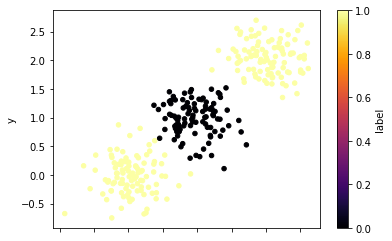

In [477]:
X, y = make_dataset('hard')

In [491]:
epochs = 10
learning_rate = 0.4
W = torch.rand((2, 1))
B = torch.zeros((1))

for _ in range(epochs):
    y_hat = torch.sigmoid(X @ W + B)
    errors = y - y_hat
    diff = y_hat * (1 - y_hat)
    print('Error - {0:.01%}'.format(torch.mean(torch.abs(errors))))
    W += learning_rate * X.T @ (errors * diff)
    B += learning_rate * torch.sum(errors * diff)

Error - 49.3%
Error - 34.8%
Error - 34.6%
Error - 34.4%
Error - 34.3%
Error - 34.2%
Error - 34.2%
Error - 34.1%
Error - 34.0%
Error - 34.0%


For this one as we know we need two layers.

In [505]:
hidden = 4
epochs = 20
learning_rate = 0.4
W_0 = torch.normal(0., 1., (2, hidden))
B_0 = torch.zeros((hidden))
W_1 = torch.normal(0., 1., (hidden, 1))
B_1 = torch.zeros((1))

diff = lambda x: x * (1 - x)

for _ in range(epochs):
    L_1 = torch.sigmoid(X @ W_0 + B_0)
    L_2 = torch.sigmoid(L_1 @ W_1 + B_1)
    errors = y - L_2
    print('Error - {0:.01%}'.format(torch.mean(torch.abs(errors))))
    
    diff_2 = errors * diff(L_2)
    diff_1 = diff_2 @ W_1.T * diff(L_1) 

    W_1 += learning_rate * L_1.T @ diff_2
    B_1 += learning_rate * torch.sum(diff_2)
    
    W_0 += learning_rate * X.T @ diff_1
    B_0 += learning_rate * torch.sum(diff_1)

Error - 49.6%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%
Error - 33.3%


Adding normal in init at this point makes training slighly more stable, but it still does not work, let's introduce a concept of a batch.

In [503]:
hidden = 4
epochs = 20
learning_rate = 0.4
W_0 = torch.normal(0., 1., (2, hidden))
B_0 = torch.zeros((hidden))
W_1 = torch.normal(0., 1., (hidden, 1))
B_1 = torch.zeros((1))

diff = lambda x: x * (1 - x)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]
        
        L_1 = torch.sigmoid(X_batch @ W_0 + B_0)
        L_2 = torch.sigmoid(L_1 @ W_1 + B_1)
        errors = y_batch - L_2
        print('Error - {0:.01%}'.format(torch.mean(torch.abs(errors))))

        diff_2 = errors * diff(L_2)
        diff_1 = diff_2 @ W_1.T * diff(L_1) 

        W_1 += learning_rate * L_1.T @ diff_2
        B_1 += learning_rate * torch.sum(diff_2)

        W_0 += learning_rate * X_batch.T @ diff_1
        B_0 += learning_rate * torch.sum(diff_1)

Error - 43.0%
Error - 37.6%
Error - 44.0%
Error - 47.6%
Error - 40.2%
Error - 47.1%
Error - 55.8%
Error - 30.0%
Error - 33.5%
Error - 43.0%
Error - 51.3%
Error - 34.8%
Error - 40.4%
Error - 41.6%
Error - 42.5%
Error - 46.4%
Error - 54.9%
Error - 31.8%
Error - 38.6%
Error - 41.6%
Error - 49.7%
Error - 34.5%
Error - 39.3%
Error - 41.2%
Error - 39.2%
Error - 42.5%
Error - 50.6%
Error - 31.1%
Error - 38.0%
Error - 40.5%
Error - 49.2%
Error - 34.1%
Error - 38.5%
Error - 39.9%
Error - 37.4%
Error - 39.7%
Error - 46.9%
Error - 30.0%
Error - 36.0%
Error - 39.1%
Error - 48.8%
Error - 33.9%
Error - 38.1%
Error - 38.2%
Error - 35.7%
Error - 36.3%
Error - 41.9%
Error - 29.0%
Error - 32.2%
Error - 36.6%
Error - 44.6%
Error - 33.8%
Error - 38.2%
Error - 35.4%
Error - 33.8%
Error - 32.2%
Error - 34.7%
Error - 28.2%
Error - 30.5%
Error - 34.1%
Error - 44.7%
Error - 34.0%
Error - 39.0%
Error - 30.9%
Error - 32.3%
Error - 30.7%
Error - 39.3%
Error - 27.4%
Error - 25.0%
Error - 28.8%
Error - 30.7%
Error 

It's still quite unstable, but batches clearly help with learning. Having normal init is also crutial.

We can easily extend this to 3 or more layers.

In [499]:
hidden = 4
epochs = 50
learning_rate = 0.4
W_0 = torch.normal(0., 1., (2, hidden))
B_0 = torch.zeros((hidden))
W_1 = torch.normal(0., 1., (hidden, hidden))
B_1 = torch.zeros((hidden))
W_2 = torch.normal(0., 1., (hidden, 1))
B_2 = torch.zeros((1))

diff = lambda x: x * (1 - x)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        L_1 = torch.sigmoid(X_batch @ W_0 + B_0)
        L_2 = torch.sigmoid(L_1 @ W_1 + B_1)
        L_3 = torch.sigmoid(L_2 @ W_2 + B_2)
        errors = y_batch - L_3
        print('Error - {0:.01%}'.format(torch.mean(torch.abs(errors))))

        diff_3 = errors * diff(L_3)
        diff_2 = diff_3 @ W_2.T * diff(L_2) 
        diff_1 = diff_2 @ W_1.T * diff(L_1) 

        W_2 += learning_rate * L_2.T @ diff_3
        B_2 += learning_rate * torch.sum(diff_3)

        W_1 += learning_rate * L_1.T @ diff_2
        B_1 += learning_rate * torch.sum(diff_2)

        W_0 += learning_rate * X_batch.T @ diff_1
        B_0 += learning_rate * torch.sum(diff_1)

Error - 41.4%
Error - 37.9%
Error - 44.8%
Error - 48.3%
Error - 43.4%
Error - 49.7%
Error - 59.3%
Error - 30.8%
Error - 34.3%
Error - 45.9%
Error - 45.7%
Error - 37.9%
Error - 43.9%
Error - 46.8%
Error - 45.1%
Error - 49.3%
Error - 54.5%
Error - 33.2%
Error - 37.5%
Error - 46.0%
Error - 44.9%
Error - 39.1%
Error - 43.8%
Error - 45.8%
Error - 45.3%
Error - 48.7%
Error - 50.7%
Error - 35.0%
Error - 39.0%
Error - 45.7%
Error - 43.7%
Error - 39.5%
Error - 43.2%
Error - 45.0%
Error - 45.1%
Error - 47.9%
Error - 48.8%
Error - 35.4%
Error - 39.5%
Error - 45.2%
Error - 43.2%
Error - 39.3%
Error - 42.3%
Error - 44.1%
Error - 44.8%
Error - 46.8%
Error - 47.3%
Error - 35.3%
Error - 39.7%
Error - 44.5%
Error - 42.8%
Error - 38.8%
Error - 41.1%
Error - 42.9%
Error - 44.3%
Error - 45.5%
Error - 45.9%
Error - 35.0%
Error - 39.8%
Error - 43.7%
Error - 42.5%
Error - 38.2%
Error - 39.8%
Error - 41.7%
Error - 43.7%
Error - 44.3%
Error - 44.4%
Error - 34.8%
Error - 39.9%
Error - 42.9%
Error - 42.1%
Error 